In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('../SelectionFunctionToolkit')

### Check selection function

In [4]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm
from astropy.coordinates import SkyCoord

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

In [7]:
%config Completer.use_jedi = False

In [8]:
from matplotlib.patches import Arrow, FancyArrow

# Minmax of data

In [8]:
sys.path.append('/home/andy/Documents/software/')
import getdata, sqlutilpy
query = """select min(phot_g_mean_mag) as min_g, max(phot_g_mean_mag) as max_g,
                  min(bp_rp) as min_c, max(bp_rp) as max_c
        from gaia_edr3.gaia_source
        where phot_g_mean_mag is not null
            and astrometric_params_solved>3
            and ruwe<1.4"""
%time minmax = sqlutilpy.get(query,asDict=True,**getdata.sql_args)
print(minmax)

CPU times: user 76 ms, sys: 20 ms, total: 96 ms
Wall time: 16min 47s
OrderedDict([('min_g', array([2.296982], dtype=float32)), ('max_g', array([21.54428], dtype=float32)), ('min_c', array([-6.520668], dtype=float32)), ('max_c', array([9.775365], dtype=float32))])


## Load in selection function

In [9]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

In [10]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [11]:
M = 85; C = 1; nside=64; jmax=5; B=2.; lm=0.3;lc=200.0
run_name = f"chisquare_ruwe1p4_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}lc{lc}_B{B}_ncores88"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}
sigma = [-0.21051177, -2.48372204]

map_fname = run_name + "_scipy_results.h5"

In [12]:
ruwe_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options=basis_options,
                lengthscale_m=0.3, lengthscale_c=3.0,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 2.979 s
  auxilliary:   0.120 s
          sf:   0.000 s
interpolator:   2.859 s


## Data

In [22]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [60]:
eps=1e-10

Mlims = [5,22]; Clims = [-1,7];

mag_res = 0.1;
M_bins = np.arange(Mlims[0], Mlims[1]+eps, mag_res)
col_res = 0.5;
C_bins = np.arange(Clims[0], Clims[1]+eps, col_res)

data_M=int((Mlims[1]-Mlims[0])/mag_res + eps);
data_C=int((Clims[1]-Clims[0])/col_res + eps);
data_nside = pow(2,7)
data_res=(data_M, data_C, hp.nside2npix(data_nside))
print('data_res: ', data_res)
sample="ruwe1p4"; file="Gres10CRres2hpx7"
box={};
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    box['n'] = np.zeros(data_res, dtype=np.int64)
    box['k'] = np.zeros(data_res, dtype=np.int64)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    try:
        if C==1: print('C=1 so no mag bounds...'); raise KeyError()
        Cidx = hf['colour'][...] - int(Clims[0]/col_res + eps)
    except KeyError: Cidx = np.zeros(len(Midx), dtype=np.int64)
    Pidx = hf['position'][...]
    in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
    for key in ['n','k']:
        box[key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
print(box['n'].shape)

data_res:  (170, 16, 196608)
C=1 so no mag bounds...
(170, 16, 196608)


In [61]:
box['n']=_downgrade(box['n'])
box['k']=_downgrade(box['k'])

M_bins = np.linspace(*Mlims, M+1)
C_bins = np.linspace(*Clims, C+1)

# Beta distribution tests of Comparison

In [62]:
g = [12.51,16.51,20.51]
c = 0

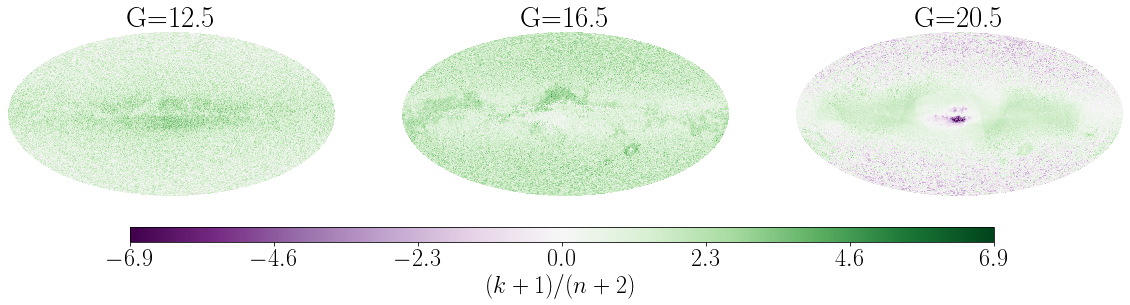

In [63]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    expected = (box['k'][g_idx,c_idx]+1)/(box['n'][g_idx,c_idx]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=24)

plt.savefig('figs/ruwe/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

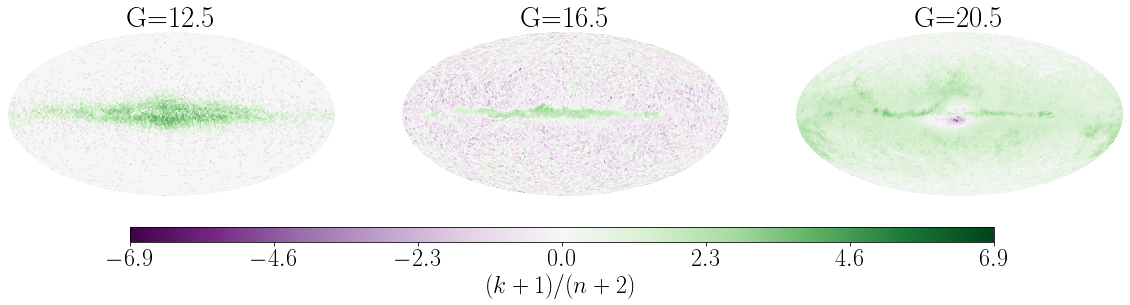

In [134]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    expected = (box['k'][g_idx,c_idx]+1)/(box['n'][g_idx,c_idx]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=24)

plt.savefig('figs/ruwe/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Load in full pixel selection function

In [17]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['b'] = f['b'][...]
    sf_box['z'] = f['z'][...]
    M_bins = np.linspace(*f['Mlim'][...], M+1)
    C_bins = np.linspace(*f['Clim'][...], C+1)

In [18]:
i=1
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

0.4438808889065016
1 0.8805584615194135
2 1.085980898006043
3 0.9585367183410638
4 0.7118246956695372
5 0.5391720043972297


(-40.080376035273645, 35.94013945248515)

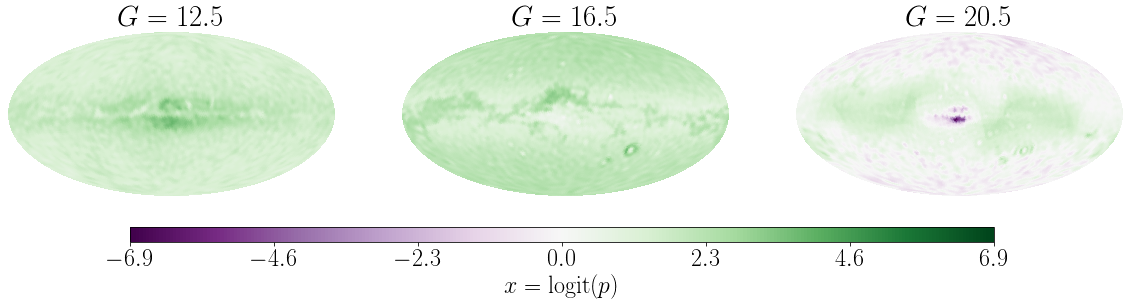

In [43]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    hp.mollview(sf_box['x'][g_idx,c_idx], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title=fr'$G={g[i]:.1f}$', cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/ruwe/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

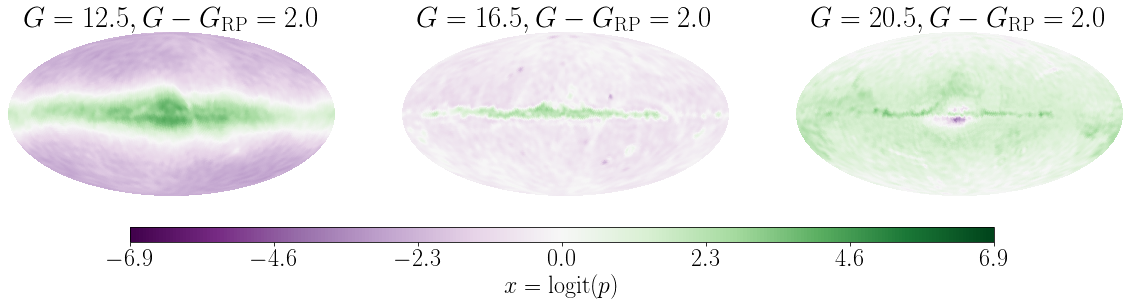

In [22]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    hp.mollview(sf_box['x'][g_idx,c_idx], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title=fr'$G={g[i]:.1f}, G-G_\mathrm{{RP}}={c:.1f}$', cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/ruwe/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

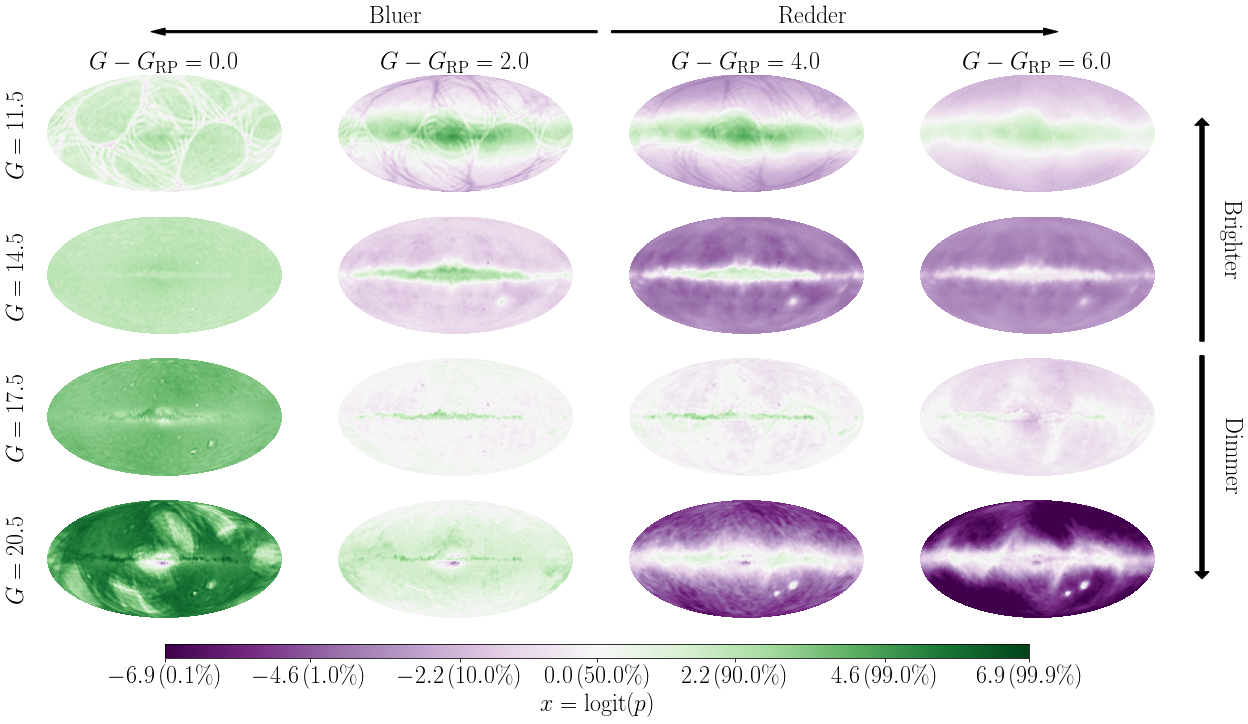

In [23]:
g = [11.51,14.51,17.51,20.51]
c = [0.,2.,4.,6.]

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(4,4,figsize=(20,10))

minmax=[np.log(1/999),np.log(0.999/0.001)]
for i in range(4):
    for j in range(4):
        plt.sca(axes[i,j])
        g_idx = np.sum(M_bins<g[i])-1
        c_idx = np.sum(C_bins<c[j])-1
        hp.mollview(sf_box['x'][g_idx,c_idx], nest=True, notext=True,min=minmax[0],max=minmax[1],
                    coord=['C','G'], title='', cmap='PRGn', hold=True, cbar=False, xsize=2000)
        if j==0: plt.text(-2.5,0.,fr'$G={g[i]:.1f}$',ha='center', va='center', rotation='vertical')
        if i==0: plt.text(0.,1.2,fr'$G-G_\mathrm{{RP}}={c[j]:.1f}$', va='center', ha='center')

arrow_kwargs = dict(fc='k', ec='k', width=0.003, head_length=0.01, head_width=0.01)
arrow_red = FancyArrow(0.51, 0.94, -0.3, 0., **arrow_kwargs); fig.add_artist(arrow_red)
fig.text(0.66, 0.96,'Redder',ha='center', va='center', rotation=0)
arrow_blue = FancyArrow(0.52, 0.94, 0.3, 0., **arrow_kwargs); fig.add_artist(arrow_blue)
fig.text(0.37, 0.96,'Bluer',ha='center', va='center', rotation=0)
arrow_bright = FancyArrow(0.93, 0.51, 0., 0.3, **arrow_kwargs); fig.add_artist(arrow_bright)
fig.text(.95, 0.65,'Brighter',ha='center', va='center', rotation=270)
arrow_dim = FancyArrow(0.93, 0.49, 0., -0.3, **arrow_kwargs); fig.add_artist(arrow_dim)
fig.text(.95, 0.35,'Dimmer',ha='center', va='center', rotation=270)

    
ax = fig.add_axes([0.21, 0.07, 0.6, 0.02]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
p=np.array([0.001,0.01,0.1,0.5,0.9,0.99,0.999]); ticks=np.log(p/(1-p))
tick_labels = [rf"${ticks[i]:.1f}\,({p[i]*100:.1f}\%)$" for i in range(len(p))]
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/ruwe/%s_x_16hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Binomial

## P-value of k

$$ p_\mathrm{value} \sim U[I_{k-1}, I_k]$$

$$ I_k = \sum_{j=0}^{k} \mathrm{Binomial}(\,j\,;\, n,\,p) $$

In [64]:
ruwe_sf.Ccenters

array([0.])

In [65]:
g = [11.51,14.51,17.51,20.51]
c = 2.

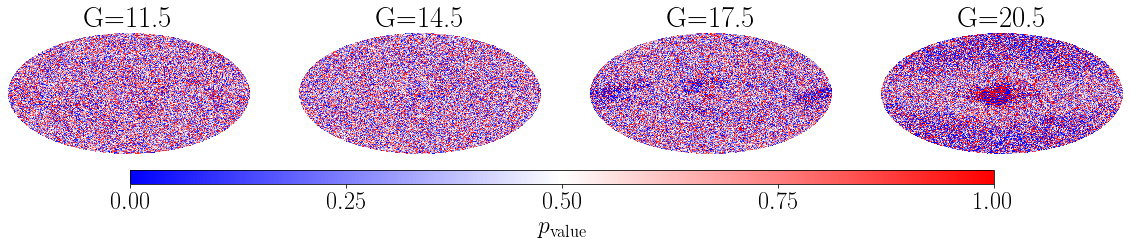

In [66]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
minmax=[0.,1.]
for i in range(4):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.25, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(0,1.01,0.25))
cbar.set_label(r'$p_\mathrm{value}$')

plt.savefig(f'figs/ruwe/{run_name}_c{c:.1f}_binompval_4hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

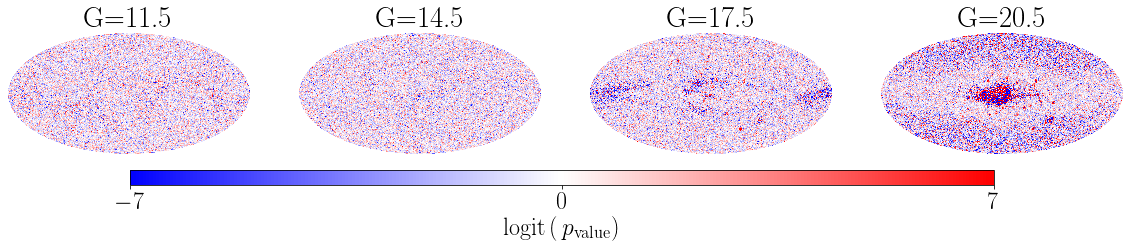

In [70]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,4,figsize=(20,5))
minmax=[-7,7]
for i in range(4):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.25, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,p_\mathrm{value}\right)$', fontsize=24)

plt.savefig('figs/ruwe/%s_logit-binompval_4hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

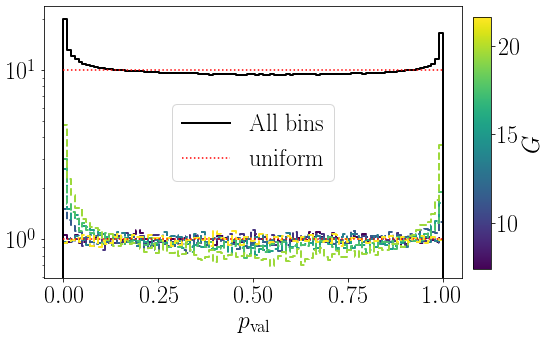

In [71]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/10)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$')


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [10,10], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='center')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$')
plt.savefig('figs/ruwe/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

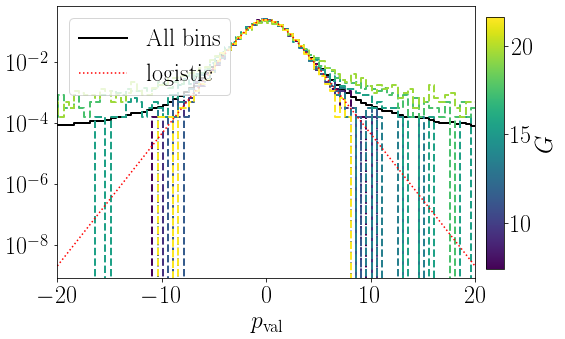

In [140]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$')

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$')

plt.savefig('figs/ruwe/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

# Using GP on b

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


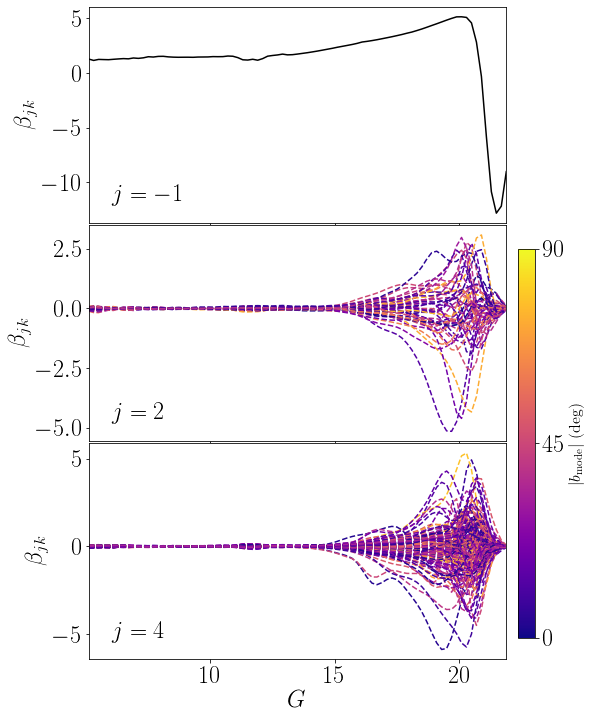

In [141]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

g = (M_bins[1:]+M_bins[:-1])/2
cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        plt.plot(g, sf_box['b'][imode,:,0], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            plt.plot(g, sf_box['b'][imode,:,0], '--', color=cmap((np.abs(b[_m]))/90))
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$\beta_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ruwe/%s_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [142]:
g = np.linspace(M_bins[0],M_bins[-1],500)
col = np.arange(ruwe_sf.Ccenters[0], ruwe_sf.Ccenters[-1]+0.01, 1.)
cc, gg = np.meshgrid(col, g)

# Contstruct covariance kernel for new positions.
KmM = ruwe_sf.covariance_kernel(gg.flatten(), ruwe_sf.Mcenters, lengthscale=ruwe_sf.lengthscale_m)
KcC = ruwe_sf.covariance_kernel(cc.flatten(), ruwe_sf.Ccenters, lengthscale=ruwe_sf.lengthscale_c)

# Estimate alm using Gaussian Process
_b = np.sum ( ((KmM @ ruwe_sf._inv_KMM) @ ruwe_sf.b) * (KcC @ ruwe_sf._inv_KCC)[None, :,:] , axis=2)
_b = _b.reshape(-1, *gg.shape)

In [143]:
def closest_pix(nside, _l, _b):
    ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True, nest=False)
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').galactic
    l,b = coord.l.rad, coord.b.rad
    gamma = np.arccos(np.sin(l[None,:])*np.sin(_l[:,None]) + np.cos(l[None,:])*np.cos(_l[:,None])*np.cos(b[None,:]-_b[:,None]))
    return gamma, np.rad2deg(l), np.rad2deg(b)

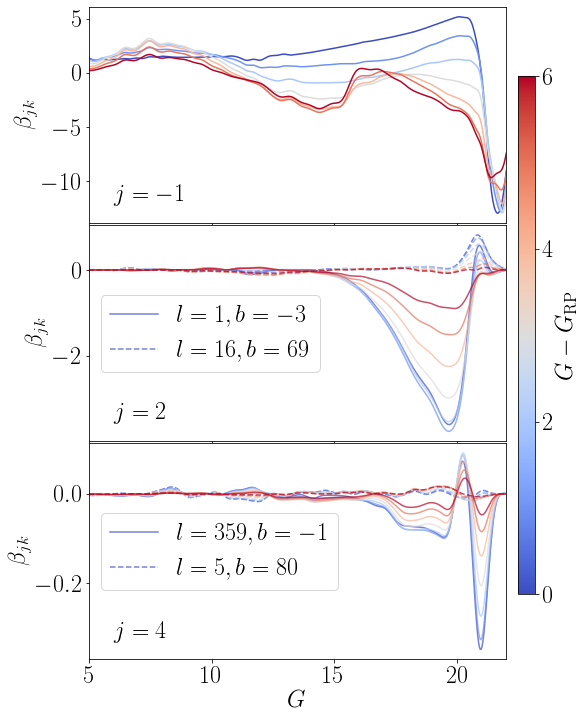

In [144]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.coolwarm

j_vals = [-1,2,4]
imode=0
pix_linestyles = ['-','--']

for iC in range(_b.shape[2]):
    rgb_color = cmap((col[iC]-col[0])/(col[-1]-col[0]))
    for i, _j in enumerate(j_vals):
        plt.sca(axes[i])
        if _j==-1:
            plt.plot(g, _b[0,:,iC], linestyle='-', color=rgb_color)
        else:
            if _j>0: imode = np.sum([hp.nside2npix(nside) for nside in 2**np.arange(_j-1)])
            else: imode=1
            gamma, l, b = closest_pix(2**_j, np.array([0.,0.]), np.array([0.,np.pi/2]))
            pix = np.argmin(gamma, axis=1)
            
            for ipix in range(2):
                if iC==0:kwargs={'alpha':0.7, 'color':rgb_color, 'label':rf"$l={l[pix[ipix]]:.0f},b={b[pix[ipix]]:.0f}$"}
                else:kwargs={'alpha':0.7, 'color':rgb_color}
                plt.plot(g, _b[imode+pix[ipix],:,iC], linestyle=pix_linestyles[ipix], **kwargs)
                
        if (iC==0)&(_j>-1): plt.legend(loc='center left')

        if iC==_b.shape[2]-1:
            ylim = axes[i].get_ylim()
            plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
            plt.ylabel(r'$\beta_{jk}$')
            
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
norm = matplotlib.colors.Normalize(vmin=col[0],vmax=col[-1])
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=ruwe_sf.Ccenters)
cbar.set_label(r'$G - G_\mathrm{RP}$', fontsize=24)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ruwe/%s_GP_col-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


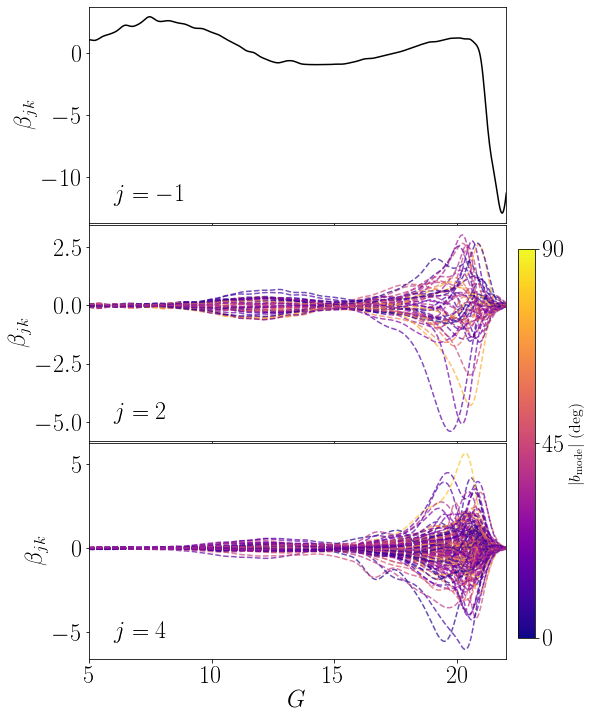

In [64]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        #plt.plot(g, _b[imode]/pychisel.sigma[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        plt.plot(g, _b[imode,:,1], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            #plt.plot(g, _b[imode]/pychisel.sigma[imode], '--', color=cmap((np.abs(b[_m]))/90))
            plt.plot(g, _b[imode,:,1], '--', color=cmap((np.abs(b[_m]))/90), alpha=0.7)
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$\beta_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ruwe/%s_GP_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)